# Montagnes VS Plages

Dans le cadre du développement de la région PACA, sachant qu'il y a un compromis entre le développement coté mer et coté montagnes, vous nous avez contacté pour répondre à la question suivante : qui préfère aller à la montagne, et qui à la plage ?

Pour répondre à cette question de la plus ahute importance, nous nous baserons sur la base de donnée mountains_vs_beaches_preferences.csv, issue de l'étude de masse que vous avez réalisé.

## Table des matières :
- [Exploration et prétraitement des données](#Exploration-et-prétraitement-des-données)
- [Visualisation des données](#Visualisation-des-données)
- [Réduction des dimensions](#Réduction-des-dimensions)
- [Recherche du meilleur modèle](#Recherche-du-meilleur-modèle)
- [Visualisation des données explicatives](#Visualisation-des-données-explicatives)
- [Synthèse et recommandations](#Synthèse-et-recommandations)
- [Prise de recul](#Prise-de-recul)

## Exploration et prétraitement des données

La base de donnée comprend plusieurs variables : 
- Age --> entier
- Gender (male/female) --> chaine de charactères
- Income --> flottant
- Education_Level --> chaine de charactères
- Travel_Frequency --> flottant
- Preferred_Activities --> chaine de charactères
- Vacation_Budget --> flottant
- Location --> chaine de charactères
- Proximity_to_Mountains --> flottant
- Proximity_to_Beaches --> flottant
- Favorite_Season --> chaine de charactères
- Pets --> booleen
- Environmental_Concerns --> booleen
- Mountains_Preference --> booleen (vaut 1 si montagne, 0 si plage) (cible)

In [1]:
# import des bibliothèques requises
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
# on liste les noms des différentes variables
var_quanti = ["Age", "Income", "Travel_Frequency", "Vacation_Budget", "Proximity_to_Mountains", "Proximity_to_Beaches"]
var_quali = ["Gender", "Education_Level", "Preferred_Activities", "Location", "Favorite_Season"]
var_bool = ["Pets", "Environmental_Concerns"]

# récupération de la base de donnée
df = pd.read_csv('mountains_vs_beaches_preferences.csv')

# affichage des premières lignes de la bd
df.head()

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Mountains_Preference
0,56,male,71477,bachelor,9,skiing,2477,urban,175,267,summer,0,1,1
1,69,male,88740,master,1,swimming,4777,suburban,228,190,fall,0,1,0
2,46,female,46562,master,0,skiing,1469,urban,71,280,winter,0,0,1
3,32,non-binary,99044,high school,6,hiking,1482,rural,31,255,summer,1,0,1
4,60,female,106583,high school,5,sunbathing,516,suburban,23,151,winter,1,1,0


In [3]:
# on vérifie qu'il ne manque aucune valeur
print(df.isnull().sum())

Age                       0
Gender                    0
Income                    0
Education_Level           0
Travel_Frequency          0
Preferred_Activities      0
Vacation_Budget           0
Location                  0
Proximity_to_Mountains    0
Proximity_to_Beaches      0
Favorite_Season           0
Pets                      0
Environmental_Concerns    0
Mountains_Preference      0
dtype: int64


In [4]:
# on vérifie que les valeurs (qualitatives et booleennes) sont toutes conformes
for col in df.columns:
    if col in var_quali + var_bool:
        print(f"Valeurs uniques dans {col}:")
        print(df[col].unique(), "\n") 

Valeurs uniques dans Gender:
['male' 'female' 'non-binary'] 

Valeurs uniques dans Education_Level:
['bachelor' 'master' 'high school' 'doctorate'] 

Valeurs uniques dans Preferred_Activities:
['skiing' 'swimming' 'hiking' 'sunbathing'] 

Valeurs uniques dans Location:
['urban' 'suburban' 'rural'] 

Valeurs uniques dans Favorite_Season:
['summer' 'fall' 'winter' 'spring'] 

Valeurs uniques dans Pets:
[0 1] 

Valeurs uniques dans Environmental_Concerns:
[1 0] 



In [5]:
## on transforme les variables qualitatives en quantitatives, en gardant en mémoire les indices correspondants.

# les valeurs pour la variable Preferred_Activities ont été attribuées de manière à séparer les deux lieux de vacance.
# on aurait pu réaliser un one-hot, mais la base de donnée aurait été trop chargée en colonne, 
# et aurait concidérablement augmenter la durée d'netrainement des modèles
correspondances = {'Gender': {'male':-1, 'female':1, 'non-binary':0}, 
                   'Education_Level': {'high school':0, 'bachelor':1, 'master':2, 'doctorate':3}, 
                   'Preferred_Activities': {'skiing':-1, 'hiking':-2, 'sunbathing':1, 'swimming':2}, 
                   'Location': {'urban':0, 'suburban':1, 'rural':2}, 
                   'Favorite_Season': {'summer':1, 'fall':2, 'winter':3, 'spring':4}}

# fabriquation d'une copie de la bd factorisée - avec des nombres à la place des chaines de charactères
df_factorisee = df.copy()

for col in var_quali:
    print(correspondances[col])
    df_factorisee[col] = df_factorisee[col].map(correspondances[col])

    # affichae des premiers termes de la base factorisée
df_factorisee.head()

{'male': -1, 'female': 1, 'non-binary': 0}
{'high school': 0, 'bachelor': 1, 'master': 2, 'doctorate': 3}
{'skiing': -1, 'hiking': -2, 'sunbathing': 1, 'swimming': 2}
{'urban': 0, 'suburban': 1, 'rural': 2}
{'summer': 1, 'fall': 2, 'winter': 3, 'spring': 4}


,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns,Mountains_Preference
0,56,-1,71477,1,9,-1,2477,0,175,267,1,0,1,1
1,69,-1,88740,2,1,2,4777,1,228,190,2,0,1,0
2,46,1,46562,2,0,-1,1469,0,71,280,3,0,0,1
3,32,0,99044,0,6,-2,1482,2,31,255,1,1,0,1
4,60,1,106583,0,5,1,516,1,23,151,3,1,1,0


## Visualisation des données

In [6]:
# on affiche les informations générales sur les données
df.describe()

,Age,Income,Travel_Frequency,Vacation_Budget,Proximity_to_Mountains,Proximity_to_Beaches,Pets,Environmental_Concerns,Mountains_Preference
count,52444.000000,52444.000000,52444.000000,52444.000000,52444.000000,52444.000000,52444.000000,52444.000000,52444.000000
mean,43.507360,70017.271280,4.489265,2741.799062,149.943502,149.888452,0.500858,0.498436,0.250706
std,14.985597,28847.560428,2.876130,1296.922423,86.548644,86.469248,0.500004,0.500002,0.433423
min,18.000000,20001.000000,0.000000,500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.000000,45048.250000,2.000000,1622.000000,75.000000,75.750000,0.000000,0.000000,0.000000
50%,43.000000,70167.000000,4.000000,2733.000000,150.000000,150.000000,1.000000,0.000000,0.000000
75%,56.000000,95108.500000,7.000000,3869.000000,225.000000,225.000000,1.000000,1.000000,1.000000
max,69.000000,119999.000000,9.000000,4999.000000,299.000000,299.000000,1.000000,1.000000,1.000000


[]

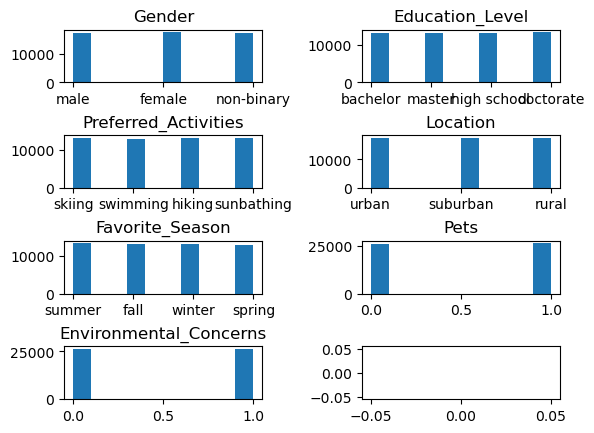

In [7]:
# affichage de la répartition des données qualitatives et booléennes
var_quali_et_bool = var_quali + var_bool
fig, axs = plt.subplots(4, 2)
for i in range(len(var_quali_et_bool)):
    axs[i//2, i%2].hist(df[var_quali_et_bool[i]])
    axs[i//2, i%2].set_title(var_quali_et_bool[i])
plt.gcf().subplots_adjust(wspace = 0.5, hspace = 1)
plt.plot()

C:\Users\tombe\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


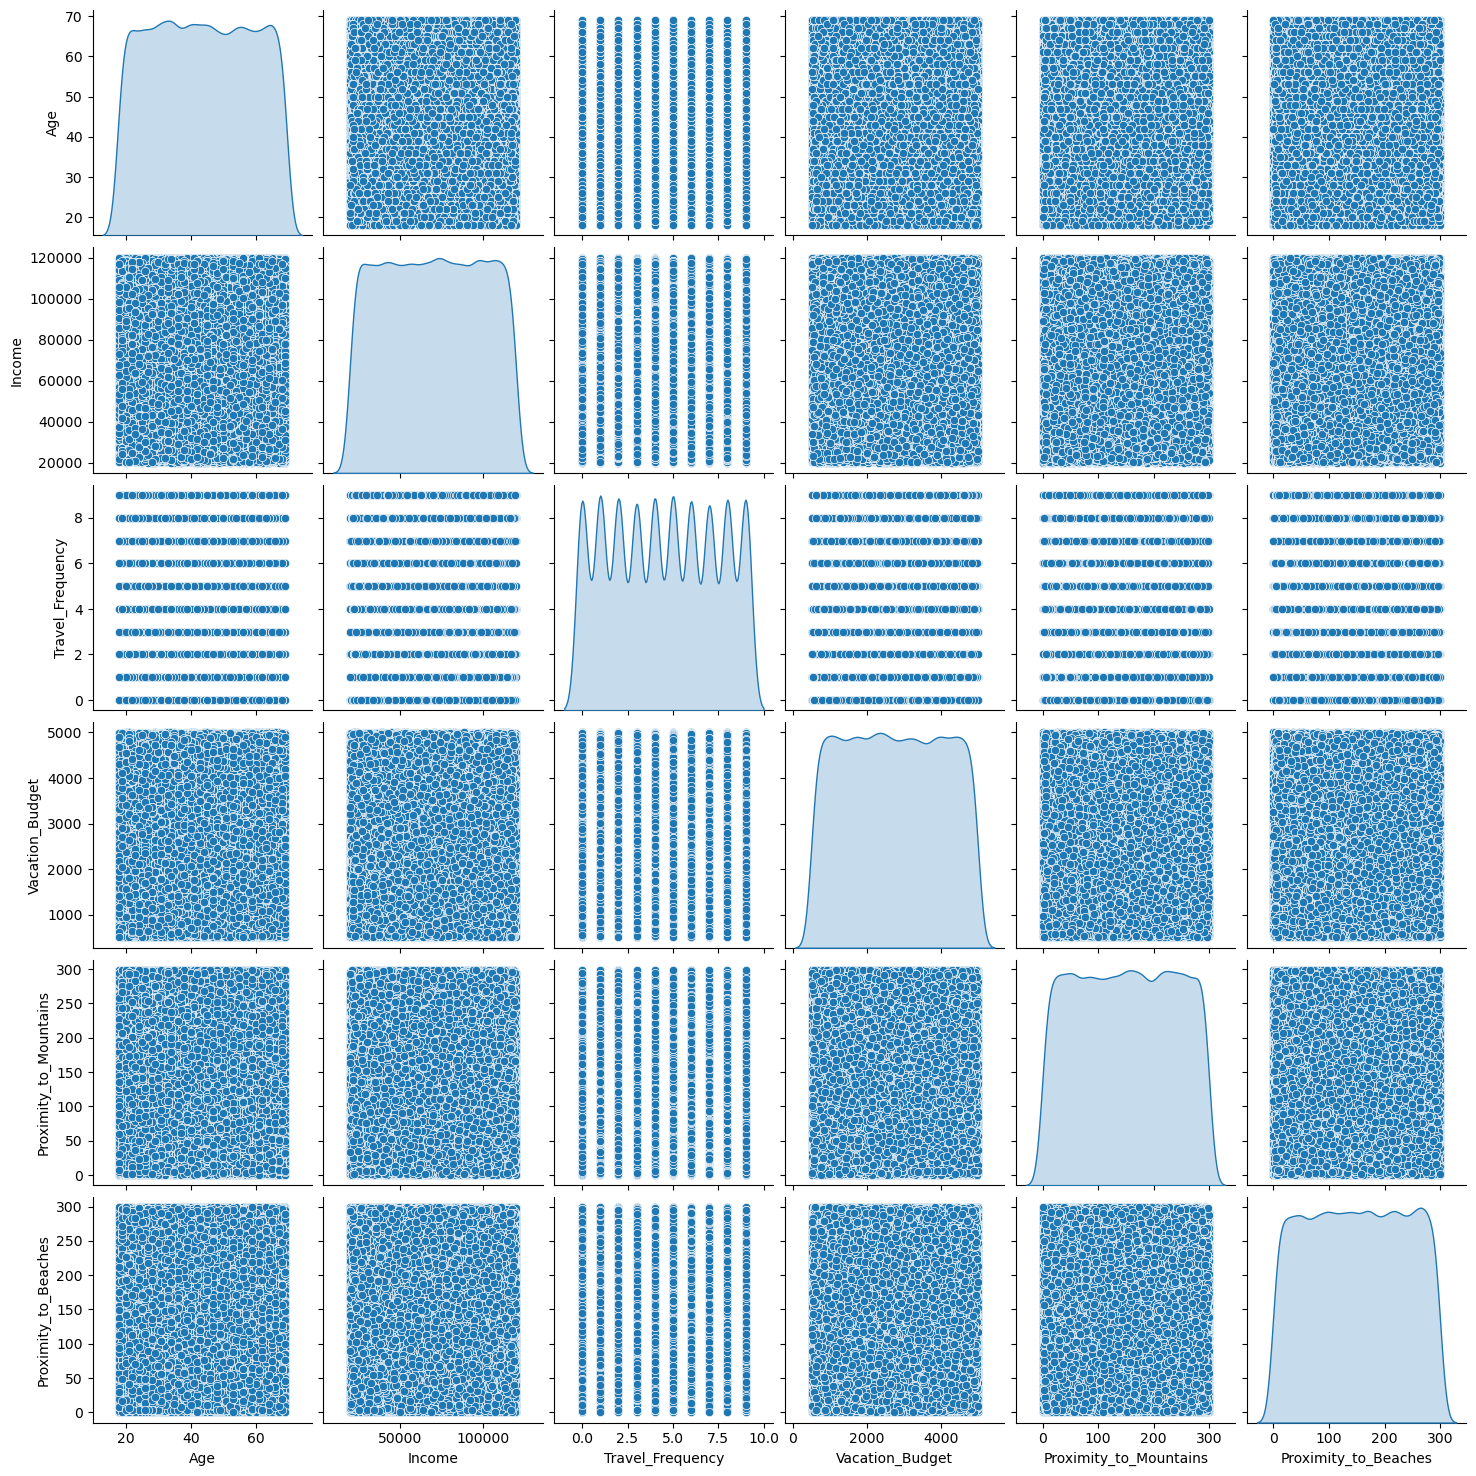

In [8]:
# affichage des correlations entre variables quantitatives (pair-plots)

df_quanti = df[["Age", "Income", "Travel_Frequency", "Vacation_Budget", "Proximity_to_Mountains", "Proximity_to_Beaches"]]

sns.pairplot(df_quanti, diag_kind="kde")
plt.show()

On observe que les données sont équitablement disrtibuées, et ne présentent pas de corrélation particulière. Essayons de réduire les dimensions de la base de donnée.

## Réduction des dimensions

In [9]:
# nous allons normaliser les données avant d'utiliser la méthode d'analyse en composante principale (ACP)
from sklearn.preprocessing import StandardScaler

# séparation des données cibles
X_pd = df_factorisee.drop('Mountains_Preference', axis=1)  
y_pd = df_factorisee['Mountains_Preference'] 

X_source, y = X_pd.to_numpy(), y_pd.to_numpy()

# normalisation des données
scaler = StandardScaler()
X = scaler.fit_transform(X_source)

,Age,Gender,Income,Education_Level,Travel_Frequency,Preferred_Activities,Vacation_Budget,Location,Proximity_to_Mountains,Proximity_to_Beaches,Favorite_Season,Pets,Environmental_Concerns
PC1,0.183478,0.109135,0.034596,0.211087,0.353990,0.417821,0.252026,-0.404074,0.323176,-0.242852,-0.326681,0.331799,-0.041999
PC2,-0.286125,0.598733,0.378552,-0.143718,-0.098381,0.171894,-0.156844,-0.244665,-0.494001,0.026896,-0.108414,0.109551,-0.059097
PC3,0.416672,0.208166,-0.018134,-0.377191,0.311788,-0.018778,-0.312211,0.191945,0.008376,-0.055325,0.242421,0.354426,0.470159
PC4,-0.351643,0.178020,-0.323369,0.414083,-0.169656,0.255491,-0.348582,0.029129,0.157958,-0.212722,0.025470,-0.154544,0.507418
PC5,0.139318,-0.160221,0.401463,0.282075,-0.422428,0.287141,0.000202,0.515366,-0.031711,-0.127052,0.007471,0.409073,-0.056026
PC6,0.139711,0.051242,0.058167,-0.022632,-0.145251,0.049680,-0.057015,0.061110,0.185255,0.719682,-0.559145,-0.044841,0.276574
PC7,0.174144,-0.098124,-0.395802,0.133463,-0.333852,-0.404641,-0.236943,-0.304912,-0.246885,-0.104881,-0.259931,0.465446,-0.071500
PC8,0.355870,0.236294,-0.027415,0.295154,-0.170232,0.138126,-0.216510,-0.279453,0.189531,0.370974,0.540138,-0.046684,-0.298585
PC9,0.123006,0.233142,-0.464480,-0.031619,-0.188168,0.223625,0.663348,0.119616,-0.323358,0.123038,0.149428,0.058335,0.169078
PC10,0.306036,-0.281364,-0.079152,-0.441189,-0.331227,0.494228,-0.203905,-0.208800,-0.102601,-0.221773,-0.116566,-0.336447,-0.024950


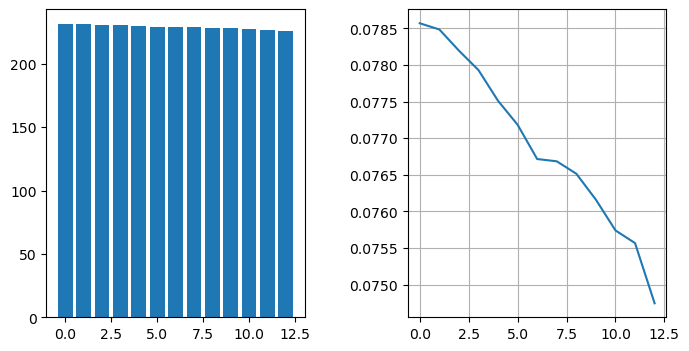

In [10]:
from sklearn.decomposition import PCA

# application de la PCA
pca = PCA(n_components=0.95) 
pca.fit(X)  

## analyse des valeurs propres
# graphique de la part de la variance expliquée par chaque variable
plt.figure(facecolor='white', figsize=[8,4])
plt.subplot(1,2,1)
plt.bar(np.arange(pca.singular_values_.shape[0]), pca.singular_values_)
plt.subplot(1,2,2)
plt.plot(pca.explained_variance_ratio_)
plt.grid()
plt.gcf().subplots_adjust(wspace = 0.4)
# valeurs en brut
pd.DataFrame(pca.components_, columns=X_pd.columns, index=[f"PC{i+1}" for i in range(pca.n_components_)])

On observe que toutes les variables expliquent de manière équitable la variance. On ne peut donc pas en retirer d'office. Une projection sur un espace de dimension inférieur ne semble pas être une bonne solution.

## Recherche du meilleur modèle

Nous allons tester différentes variables pour différents modèles et sélectionner les meilleures pour chacun d'eux. 
Nous étudierons quel est le meilleur modèle dans un second temps.

### Modèles testés :
- [Régression Logistique](#Régression-Logistique)
- [Random Forest](#Random-Forest)
- [Support Vector Machines (SVM)](#Support-Vector-Machines-(SVM))
- [Elastic Net](#Elastic-Net)
- [Algorithme des k plus proches voisins (KNN)](#Algorithme-des-k-plus-proches-voisins-(KNN))
- [XG Boost](#XG-Boost)


In [11]:
# on divise les données pour l'apprentissage et les tests
from sklearn.model_selection import train_test_split

# on sépare les données en deux
# (5% pour l'entraînement et 95% pour le test à cause du grand nombre de donnée)
X_app, X_test, y_app, y_test = train_test_split(X, y, test_size=0.95)

### Régression Logistique

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

model_reglog = LogisticRegression()

param_grid = {'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
grid_search = GridSearchCV(model_reglog, param_grid, cv=5)

# Entraînement sur les données
grid_search.fit(X_app, y_app)

# Meilleur modèle avec l'hyperparamètre optimal
model_reglog_params = grid_search.best_params_
print("Meilleurs paramètres :", model_reglog_params)

# Évaluation sur les données de test
score = grid_search.score(X_test, y_test)
print("Score sur les données de test :", score)

Meilleurs paramètres : {'C': 0.1}
Score sur les données de test : 0.9276825498775642


### Random Forest

In [13]:
from sklearn.ensemble import RandomForestClassifier

model_randfor = RandomForestClassifier()

param_grid = {'min_samples_split': [2, 5, 10]}
grid_search = GridSearchCV(model_randfor, param_grid, cv=5)

# Entraînement sur les données
grid_search.fit(X_app, y_app)

# Meilleur modèle avec l'hyperparamètre optimal
model_randfor_params = grid_search.best_params_
print("Meilleur paramètres :", model_randfor_params)

# Évaluation sur les données de test
score = grid_search.score(X_test, y_test)
print("Score sur les données de test :", score)

Meilleur paramètres : {'min_samples_split': 5}
Score sur les données de test : 0.9812934045200915


### Support Vector Machines (SVM)

In [14]:
from sklearn.svm import SVC

model_svc = SVC()

param_grid = [
    {"C": [0.1,1,5,10,100]},
    {"kernel": ["linear"]},
    {"gamma": [0.1, 0.5, 1, 2, 5],
    "kernel": ["rbf"]}
]

# l'execution dure une dixaine de secondes
grid_search = GridSearchCV(model_svc, param_grid, cv=5)

# Entraînement sur les données
grid_search.fit(X_app, y_app)

# Meilleur modèle avec l'hyperparamètre optimal
model_svc_params = grid_search.best_params_
print("Meilleurs paramètres :", model_svc_params)

# Évaluation sur les données de test
score = grid_search.score(X_test, y_test)
print("Score sur les données de test :", score)

Meilleurs paramètres : {'C': 100}
Score sur les données de test : 0.9723816787764441


### Elastic Net

In [15]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import ElasticNet

# comme le modèle d'Elastic Net ne permet pas de cross_validation (méthode utilisée pour comparer les modèles)
# nous allons devoir créer une classe de classifieur avec un modèle de prédiction modifié, 
# permettant de classifier les données dont le résulat est au delà d'un seuil (threshold, ici 0.5)
class ElasticNetClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=1.0, l1_ratio=0.5, threshold=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.threshold = threshold
        self.model = ElasticNet(alpha=self.alpha, l1_ratio=self.l1_ratio)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        y_pred = self.model.predict(X)
        return (y_pred > self.threshold).astype(int)  # ou np.round(y_pred) pour multi-classes

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

model_elanet = ElasticNetClassifier()

param_grid = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]}        

grid_search = GridSearchCV(model_elanet, param_grid, cv=5)

# Entraînement sur les données
grid_search.fit(X_app, y_app)

# Meilleur modèle avec l'hyperparamètre optimal
model_elanet_params = grid_search.best_params_
print("Meilleurs paramètres :", model_elanet_params)

# Évaluation sur les données de test
score = grid_search.score(X_test, y_test)
print("Score sur les données de test :", score)

Meilleurs paramètres : {'alpha': 0.0001}
Score sur les données de test : 0.7492874633695957


### Algorithme des k plus proches voisins (KNN)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

model_knncla = KNeighborsClassifier()

param_grid = {'n_neighbors': [3, 5, 7, 10, 15],
             'metric': ['euclidean', 'manhattan', 'minkowski']}  
grid_search = GridSearchCV(model_knncla, param_grid, cv=5)

# Entraînement sur les données
grid_search.fit(X_app, y_app)

# Meilleur modèle avec l'hyperparamètre optimal
model_knncla_params = grid_search.best_params_
print("Meilleurs paramètres :", model_knncla_params)

# Évaluation sur les données de test
score = grid_search.score(X_test, y_test)
print("Score sur les données de test :", score)

Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 15}
Score sur les données de test : 0.92073782666292


### XG Boost

In [17]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier()

param_grid = {'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]}
grid_search = GridSearchCV(model_xgb, param_grid, cv=5)

# Entraînement sur les données
grid_search.fit(X_app, y_app)

# Meilleur modèle avec l'hyperparamètre optimal
model_xgb_params = grid_search.best_params_
print("Meilleurs paramètres :", model_xgb_params)

# Évaluation sur les données de test
score = grid_search.score(X_test, y_test)
print("Score sur les données de test :", score)

Meilleurs paramètres : {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}
Score sur les données de test : 0.9902452731724941


### Comparaison des meilleurs modèles

In [18]:
from sklearn import naive_bayes
from sklearn.model_selection import cross_val_score
import time

# on prépare tous les modèles que nous allons comparer
modeles_classif = {
    "Naive Bayes" : naive_bayes.GaussianNB(),
    "Logistic Regression": LogisticRegression(C = model_reglog_params['C']),
    "Random Forest": RandomForestClassifier(min_samples_split = model_randfor_params['min_samples_split']),
    "SVM": SVC(C = model_svc_params['C']),
    "Elastic Net" : ElasticNetClassifier(alpha = model_elanet_params['alpha']),
    "KNN" : KNeighborsClassifier(metric = model_knncla_params['metric'], n_neighbors = model_knncla_params['n_neighbors']),
    "XGBoost": XGBClassifier(learning_rate = model_xgb_params['learning_rate'], max_depth = model_xgb_params['max_depth'], n_estimators = model_xgb_params['n_estimators'])
}

mean_scores = []
std_scores = []
model_names = []
test_scores = []
temps_score = []

for name, model in modeles_classif.items():
    # calcul des scores sur données d'apprentissage (valisation croisée)
    scores = cross_val_score(model, X_app, y_app, cv=5, scoring='accuracy')
    mean_scores.append(scores.mean())
    std_scores.append(scores.std())
    model_names.append(name)
    
    # calcul des scores sur le jeu de test
    T = time.time()
    model.fit(X_app, y_app)
    Tf = time.time() - T
    y_pred = np.where(model.predict(X_test) > 0.5, 1, 0)
    test_acc = accuracy_score(y_test, y_pred)
    test_scores.append(test_acc)
    temps_score.append(Tf)

# rassemblement des données
n_models = len(model_names)
results = {"modèles classif." : model_names, 
            "accuracy moyenne (app)" : mean_scores,
            "écart type accuracy (app)" : std_scores,
            "accuracy (test)" : test_scores,
            "temps d'apprentissage (s)" : temps_score,
            }

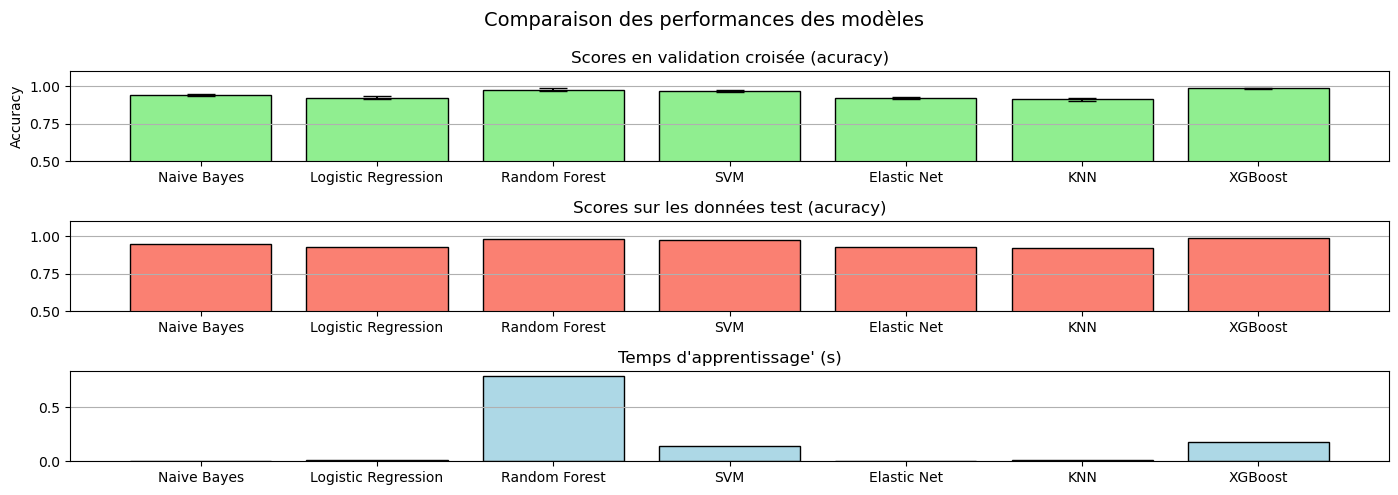

In [19]:
# affichage des résultats sous forme de graphiques
fig, axs = plt.subplots(3, 1, figsize=(14, 5))

# cross-validation
axs[0].bar(model_names, mean_scores, yerr=std_scores, capsize=10, color='lightgreen', edgecolor='black')
axs[0].set_title("Scores en validation croisée (acuracy)")
axs[0].set_ylabel("Accuracy")
axs[0].set_ylim(0.5, 1.1)
axs[0].grid(axis='y')

# scores sur les données test
axs[1].bar(model_names, test_scores, color='salmon', edgecolor='black')
axs[1].set_title("Scores sur les données test (acuracy)")
axs[1].set_ylim(0.5, 1.1)
axs[1].grid(axis='y')

# temps d'apprentissage
axs[2].bar(model_names, temps_score, color='lightblue', edgecolor='black')
axs[2].set_title("Temps d'apprentissage' (s)")
axs[2].grid(axis='y')

plt.suptitle("Comparaison des performances des modèles", fontsize=14)
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.show()

In [20]:
# aficher les resultats en brut
pd.DataFrame(data = results)

,modèles classif.,accuracy moyenne (app),écart type accuracy (app),accuracy (test),temps d'apprentissage (s)
0,Naive Bayes,0.943937,0.005460,0.948457,0.002506
1,Logistic Regression,0.924872,0.008182,0.927683,0.010553
2,Random Forest,0.977874,0.009245,0.982076,0.795990
3,SVM,0.967580,0.004841,0.972382,0.140523
4,Elastic Net,0.923346,0.005511,0.927361,0.002008
5,KNN,0.913804,0.009707,0.920738,0.008514
6,XGBoost,0.986265,0.005323,0.990245,0.175170


Nous nous attendions bien à ce que le modèle ElaticNet soit moins performant car est plus adapté pour des modèles de régression.

Nous observons que parmis les modèles les plus performants (Random Forest, SVM et XGBoost), XGBoost est le plus rapide. Nous allons donc garder ce modèle pour la suite.

### Explorer la sensibilité du modèle choisi

Aire sous la courbe (AUC) = 0.99968


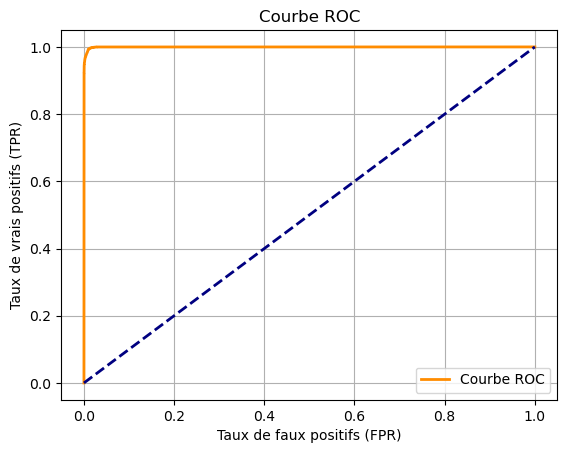

In [21]:
# nous allons tester le modèle par une autre approche, complémentaire à l'accuracy. 
# Elle repose sur le taux de vrias positifs et de faux positifs (rappel).
# Nous tracerons la courbe ROC, ce qui permettra d'estimer la fiabilité du modèle.

from xgboost import XGBClassifier
from sklearn.metrics import roc_curve, auc

# on initialise le meilleur modèle séléctionné
best_model = XGBClassifier(learning_rate = model_xgb_params['learning_rate'], 
                           max_depth = model_xgb_params['max_depth'], 
                           n_estimators = model_xgb_params['n_estimators'])

best_model.fit(X_app, y_app)

# prédiction des probabilités
y_probs = best_model.predict_proba(X_test)[:, 1]  # Probabilité de préférence pour la montagne

# calcul des points de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# tracer la courbe
print("Aire sous la courbe (AUC) =", round(roc_auc, 5))
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

L'AUC est très proche de 1. Cela signifie que le modèle est capable de classer très efficacement les personnes qui préfèrent la montagne dans les données de test. Ce test est complémentaire à l'accuracy, et nous permet de valider le modèle choisi. Nous pouvons donc nous demander quelles variables ont permis au modèle d'être aussi précis.

## Visualisation des données explicatives

Comme nous n'avons pas altéré les données (PCA), nous pouvons chercher quelles variables sont les plus importantes pour la classification.

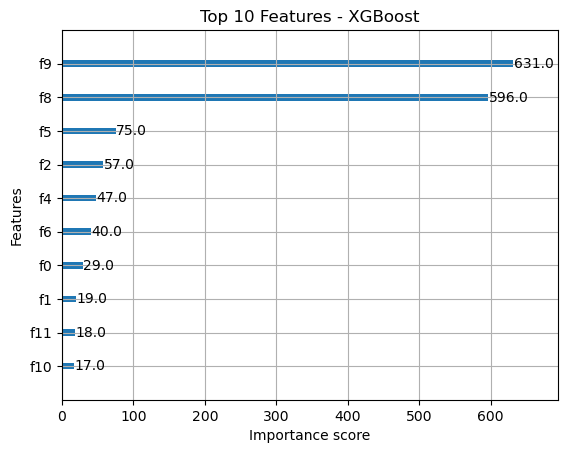

In [22]:
# regardons quelles variables ont permis une bonne classification de la part du modèle
from xgboost import plot_importance

# premier appercu rapide
plot_importance(best_model, max_num_features=10)
plt.title('Top 10 Features - XGBoost')
plt.show()

100%|===================| 49808/49822 [03:30<00:00]        

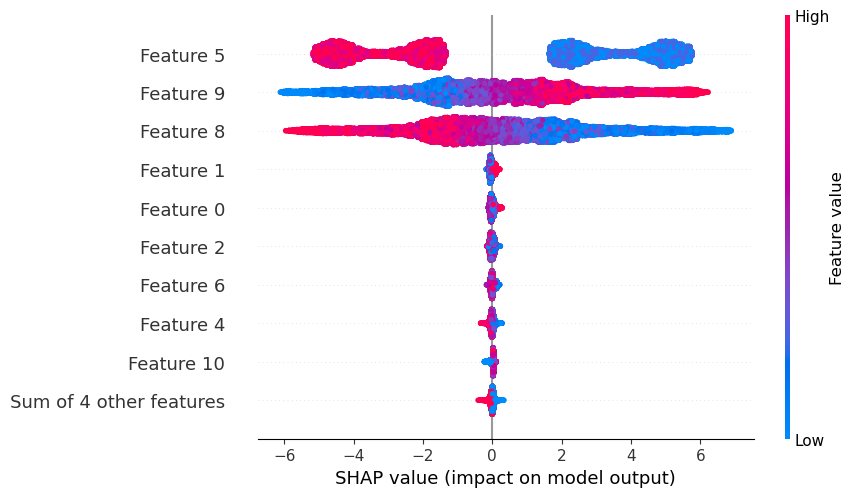

In [23]:
# les valeurs SHAP vont nous permettre de représenter comment les variables influence notre modèle.
# si nécessaire :
# !pip install shap
import shap

# second appercu plus détaillé /!\ temps d'execution : 4 minutes
# --> le graphique qui a été produit durant la phase de développement du notebook est affiché en dessous
explainer = shap.Explainer(best_model, X_app)
shap_values = explainer(X_test)

# affichage du résumé global
shap.plots.beeswarm(shap_values)



#### Voici la figure obtenue lors de la phase de développement du notebook :

<img src=montagne_shap.png>

Les points bleus et rouges représentent respectivement les valeurs faibles et élevées de chaque variable. La SHAP value est un float qui indique si la variable à tendence à indiquer une valeur de sortie faible (proche de 0 donc préférence de plage) ou élevée (proche de 1 donc préférence de montagne). 

Ainsi, on observe que le lieu de vacance est largement influencé par les variables 5, 8 et 9, qui correspondent respectivement aux activitées préférées (activités de plage > 0), à la distance à la montagne (influence le modèle vers la plage quand elle augmente), et à la distance aux plages (influence vers la montagne quand elle augmente).

L'absence de la variable 5 dans la première visualisation peut être expliquée par les valeurs proches des facteurs créés (-2, -1, 1 et 2). Leur impact sur la sortie du modèle n'est donc surement pas très grande selon cette première approche.

### Etude de l'impact de l'élimination des variables sur l'AUC

Essayons de simplifier les modèles en supprimant les variables qui sont moins corrélées à la préférence des gens.

AUC [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] = 0.99969
AUC [5, 9, 8] = 0.9997
AUC [5, 8] = 0.93537
AUC [9, 8] = 0.83392
AUC [9] = 0.68875
AUC [8] = 0.69356
AUC [5] = 0.83277


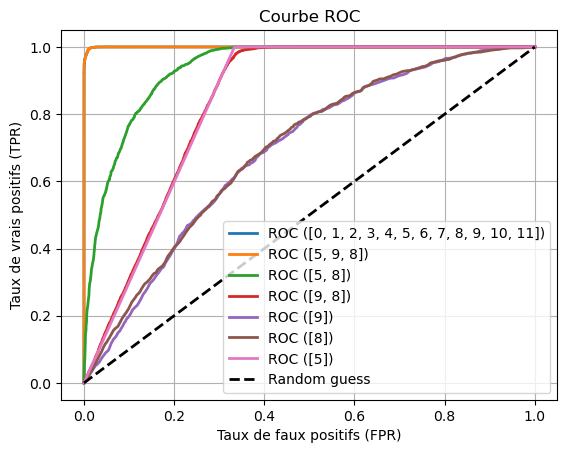

In [24]:
# initialisons le meilleur modèle retenu
best_model = XGBClassifier(learning_rate = model_xgb_params['learning_rate'], 
                           max_depth = model_xgb_params['max_depth'], 
                           n_estimators = model_xgb_params['n_estimators'])

# préparation des différentes variables prises en compte
var_selected = [[x for x in range(12)], [5, 9, 8], [5, 8], [9, 8], [9], [8], [5]]

# tracer des courbes ROC
plt.figure()

for vs in var_selected:
    best_model.fit(X_app[:, vs], y_app)

    y_probs = best_model.predict_proba(X_test[:, vs])[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    print(f"AUC {vs} =", round(roc_auc, 5))
    plt.plot(fpr, tpr, lw=2, label=f"ROC ({vs})")
    
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')
plt.xlabel('Taux de faux positifs (FPR)')
plt.ylabel('Taux de vrais positifs (TPR)')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.grid()
plt.show()

On peut observer que les variables 5, 9 et 8 sont bien suffisantes pour construire un modèle simple et efficace.
Essayons de comparer les modèles avant et après réduction des dimensions, avec seulement ces trois variables pour voir si cela a eu un impact négatif sur les modèles.

In [25]:
# on réduit les données à 3 variables explicatives
X_app_red, X_test_red, y_app_red, y_test_red = train_test_split(X[:, [5, 8, 9]], y, test_size=0.95, random_state=42)

# on réinitialise tous les modèles 
modeles_classif_red = {
    "Naive Bayes" : naive_bayes.GaussianNB(),
    "Logistic Regression": LogisticRegression(C = model_reglog_params['C']),
    "Random Forest": RandomForestClassifier(min_samples_split = model_randfor_params['min_samples_split']),
    "SVM": SVC(C = model_svc_params['C']),
    "Elastic Net" : ElasticNetClassifier(alpha = model_elanet_params['alpha']),
    "KNN" : KNeighborsClassifier(metric = model_knncla_params['metric'], n_neighbors = model_knncla_params['n_neighbors']),
    "XGBoost": XGBClassifier(learning_rate = model_xgb_params['learning_rate'], max_depth = model_xgb_params['max_depth'], n_estimators = model_xgb_params['n_estimators'])
}

mean_scores_red = []
std_scores_red = []
test_scores_red = []
temps_score_red = []

for name, model in modeles_classif_red.items():
    # scores sur l'apprentissage par validation croisée
    scores = cross_val_score(model, X_app_red, y_app_red, cv=5, scoring='accuracy')
    mean_scores_red.append(scores.mean())
    std_scores_red.append(scores.std())
    
    # scores sur le jeu de test
    T = time.time()
    model.fit(X_app_red, y_app_red)
    Tf = time.time() - T
    y_pred = np.where(model.predict(X_test_red) > 0.5, 1, 0)
    test_acc = accuracy_score(y_test_red, y_pred)
    test_scores_red.append(test_acc)
    temps_score_red.append(Tf)
    
n_models = len(model_names)
results_red = {"modèles classif." : model_names, 
                "accuracy moyenne (app)" : mean_scores_red,
                "évolution acc. moy. app." : [mean_scores_red[x] - mean_scores[x] for x in range(n_models)],
                "écart type accuracy (app)" : std_scores_red,
                "évolution acc. std. app." : [std_scores_red[x] - std_scores[x] for x in range(n_models)],
                "accuracy (test)" : test_scores_red,
                "évolution acc. test" : [test_scores_red[x] - test_scores[x] for x in range(n_models)],
                "temps d'apprentissage (s)" : temps_score_red,
                "évolution temps (s)" : [temps_score_red[x] - temps_score[x] for x in range(n_models)]
            }

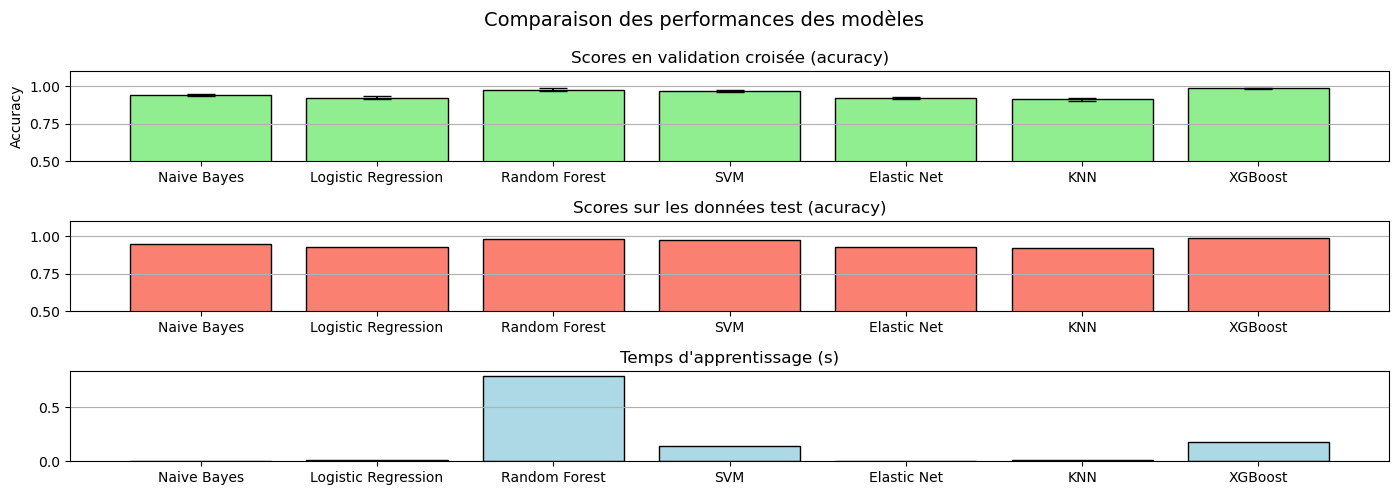

In [26]:
# afficher les résultats sous forme de graphiques
fig, axs = plt.subplots(3, 1, figsize=(14, 5))

# cross-validation
axs[0].bar(model_names, mean_scores, yerr=std_scores, capsize=10, color='lightgreen', edgecolor='black')
axs[0].set_title("Scores en validation croisée (acuracy)")
axs[0].set_ylabel("Accuracy")
axs[0].set_ylim(0.5, 1.1)
axs[0].grid(axis='y')

# scores sur les données test
axs[1].bar(model_names, test_scores, color='salmon', edgecolor='black')
axs[1].set_title("Scores sur les données test (acuracy)")
axs[1].set_ylim(0.5, 1.1)
axs[1].grid(axis='y')

# temps du procesus complet
axs[2].bar(model_names, temps_score, color='lightblue', edgecolor='black')
axs[2].set_title("Temps d'apprentissage (s)")
axs[2].grid(axis='y')

plt.suptitle("Comparaison des performances des modèles", fontsize=14)
plt.gcf().set_facecolor('white')
plt.tight_layout()
plt.show()

In [27]:
# aficher les résultats en brut
pd.DataFrame(data = results_red)

,modèles classif.,accuracy moyenne (app),évolution acc. moy. app.,écart type accuracy (app),évolution acc. std. app.,accuracy (test),évolution acc. test,temps d'apprentissage (s),évolution temps (s)
0,Naive Bayes,0.941259,-0.002678,0.009944,0.004483,0.946590,-0.001867,0.002000,-0.000506
1,Logistic Regression,0.931729,0.006857,0.005348,-0.002834,0.928867,0.001184,0.006620,-0.003933
2,Random Forest,0.984744,0.006870,0.003196,-0.006049,0.990827,0.008751,0.502820,-0.293170
3,SVM,0.994661,0.027081,0.003693,-0.001148,0.997551,0.025170,0.031305,-0.109218
4,Elastic Net,0.931728,0.008382,0.009783,0.004272,0.928887,0.001525,0.002000,-0.000008
5,KNN,0.984364,0.070561,0.004414,-0.005293,0.986151,0.065413,0.004529,-0.003985
6,XGBoost,0.984745,-0.001520,0.005118,-0.000205,0.990185,-0.000060,0.220866,0.045696


Le temps d'apprentissage des modèles est bien meilleur, et les scores ne diffèrent pas de la première simulation, voire augmentent légèrement. Cette réduction de dimension est une bonne manière de simplifier l'entrainement des modèles.

## Synthèse et recommandations

En conclusion, d'après ce jeu de données, les variables qui expliquent le plus la préférence des vancanciers pour la montagne sont (resp. à la plage) :
- des préférences pour les activités de montagnes (randonnée et ski) (resp. pour les acticités de plage ; baignade et bronzage);
- la proximité à la montagne (resp. la proximité à la plage)
- l'éloignement à la plage (resp. l'éloignement à la montagne)

Les autres variables ne permettent pas d'améliorer le modèle, et peuvent même diminuer très légèrement ses performances (comme pour Random Forest). 

Le meilleur modèle serait donc un modèle xgboost avec comme paramètres un taux d'apprentissage à 0.2, une profondeur maximale à 5, et un nombre d'estimateur de 200.

Pour les prochaines études, il serait peut être judicieux d'ajouter de nouveaux paramètres qui peuvent compéter le modèle, comme la présence de la personne sur les réseaux sociaux, sa forme physique ou son type d'hébergement préférée.

## Prise de recul

Pour réaliser cette étude, la principale difficulté a été d'entrainer les modèles sur l'ensemble des données (12 colonnes) rendant l'entrainement des modèles plutôt long, et ainsi réduisant le champ des hyperparamètres possibles à tester dans un temps résonnable (pour les SVM notamment).  Nous nous somme en effet basé seulement sur l'ACP, alors que nous aurions pu mettre en place une élimination successive des dimensions (en forward) et tester l'efficacité des modèles sur ces résultats. Nous aurions également pu prendre en compte des méthodes de régularisation comme lasso ou elastic net, qui auraient pu nous aider à séléctionner les variables.

Source de la bd : https://www.kaggle.com/datasets/jahnavipaliwal/mountains-vs-beaches-preference